<a href="https://colab.research.google.com/github/Tejaswini1309/Satellite-Imagery-Based-Property-Valuation/blob/main/price_prediction_and_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/project_cdc/test_images.zip /content/test.zip
!unzip -q /content/test.zip -d /content/test_data

Mounted at /content/drive


In [2]:
!ls /content/test_data/test | head -n 5
!ls /content/test_data/test | wc -l

1000102.png
100100050.png
1001200035.png
100300500.png
1005000036.png
5396


In [3]:
!cp "/content/drive/MyDrive/project_cdc/test2.csv" /content/test2.csv

In [4]:
import pandas as pd
df = pd.read_csv("/content/test2.csv")
df.shape[0]

5404

In [5]:
df['date']=pd.to_datetime(df['date'],format = '%Y%m%dT%H%M%S')
df['year_sold'] = df['date'].dt.year
df['month_sold'] = df['date'].dt.month

In [6]:
df['house_age'] = df['year_sold']-df['yr_built']
df.drop(columns=['date'],inplace=True)

In [7]:
num_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated','lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'house_age']

In [8]:
import joblib
scaler = joblib.load("/content/drive/MyDrive/project_cdc/scaler.pkl")
le_zip = joblib.load("/content/drive/MyDrive/project_cdc/zipcode_encoder1.pkl")

In [9]:
df['zipcode'].value_counts()

,count
zipcode,
98034,156
98115,146
98052,145
98103,144
98038,141
...,...
98102,26
98010,25
98024,22


In [10]:
df['zipcode']=df['zipcode'].astype(str)
df.loc[~df['zipcode'].isin(le_zip.classes_),'zipcode']='UNK'
df['zipcode'] = le_zip.transform(df['zipcode'])
df[num_features] = scaler.transform(df[num_features])

In [11]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std = [0.229, 0.224, 0.225])
])

In [12]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class HouseDataset(Dataset):
    def __init__(self, df, image_dir, features, transform):
        self.df = df
        self.image_dir = image_dir
        self.features = features
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]


        x_tab = torch.tensor(
            row[self.features].values,
            dtype=torch.float32
        )

        zipcode = torch.tensor(
            int(row["zipcode"]),
            dtype=torch.long
        )

        house_id = str(int(row["id"]))
        img_path = os.path.join(self.image_dir, f"{house_id}.png")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {
            "id": row['id'],
            "tabular": x_tab,
            "zipcode": zipcode,
            "image": image
        }

In [13]:
num_features=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront','view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated','lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'house_age']

In [14]:
test_dataset = HouseDataset(df,"/content/test_data/test",num_features,transform)

In [15]:
test_dataset[0]

{'id': np.float64(2591820310.0),
 'tabular': tensor([ 0.7040,  0.1808, -0.0043, -0.1537,  0.9312,  0.0000, -0.3048,  0.9142,
          0.2940,  0.3399, -0.6530,  0.5051, -0.2111, -0.8760,  0.3717,  0.5906,
         -0.1873, -0.6895,  1.1000, -0.5161]),
 'zipcode': tensor(32),
 'image': tensor([[[-0.4226, -0.5424, -0.4054,  ..., -0.9705, -1.2445, -1.2274],
          [-0.4226, -0.5253, -0.4226,  ..., -1.2445, -1.3644, -1.2274],
          [-0.8164, -0.8164, -0.6965,  ..., -1.2445, -1.2445, -1.3644],
          ...,
          [-0.6794, -1.2103, -1.2274,  ..., -0.9705, -0.8335, -0.6794],
          [-0.5253, -0.7993, -0.8335,  ..., -0.9705, -0.8335, -0.8335],
          [-0.9534, -0.9534, -0.6623,  ..., -0.2684, -0.5424, -0.5424]],
 
         [[ 0.1176,  0.1001,  0.2227,  ..., -0.7052, -1.1078, -0.8627],
          [ 0.1176,  0.1176,  0.1176,  ..., -0.9853, -1.1253, -0.9853],
          [-0.3200, -0.3200, -0.1275,  ..., -0.9853, -0.9853, -1.0028],
          ...,
          [-0.3025, -0.7052, -0.8

In [16]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

In [17]:
import torchvision.models as models
resnet = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


In [18]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
for param in resnet.parameters():
    param.requires_grad = True
resnet = resnet.to(device)


In [20]:
import torch.nn as nn
num_f=resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_f,256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,64)
)

In [21]:
class Model(nn.Module):
  def __init__(self,resnet,num_tab_features,num_zipcodes):
    super().__init__()
    self.resnet = resnet
    self.zipcode_embedding = nn.Embedding(num_zipcodes,10)
    self.nn_tab = nn.Sequential(
        nn.Linear(num_tab_features,64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.2),
        nn.Linear(64,32),
        nn.ReLU()
    )
    self.final_mlp = nn.Sequential(
        nn.Linear(64+10+32,64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64,1)
    )
  def forward(self,x_tab,zipcode,image):
    img_feat = self.resnet(image)
    zip_feat = self.zipcode_embedding(zipcode)
    tab_feat = self.nn_tab(x_tab)

    x = torch.cat([img_feat, zip_feat, tab_feat], dim=1)
    return self.final_mlp(x).squeeze(1)


In [22]:
num_zipcodes = len(le_zip.classes_)

In [23]:
num_zipcodes

70

In [24]:
model = Model(
    resnet=resnet,
    num_tab_features=len(num_features),
    num_zipcodes=num_zipcodes
).to(device)

checkpoint = torch.load("/content/drive/MyDrive/project_cdc/last_model1.pt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [25]:
price_scaler = joblib.load("/content/drive/MyDrive/project_cdc/price_scaler.pkl")

In [26]:
results=[]
with torch.no_grad():
   for batch in test_loader:
    ids = batch["id"]
    x_tab = batch["tabular"].to(device)
    zipcode = batch["zipcode"].to(device)
    image = batch["image"].to(device)
    y_pred = model(x_tab,zipcode,image)

    y_pred = y_pred.cpu().numpy().reshape(-1,1)

    y_pred_unscaled = price_scaler.inverse_transform(y_pred)
    y_pred = y_pred_unscaled.reshape(-1)

    for i in range(len(ids)):
      results.append({"id":int(ids[i]),"price_price":y_pred[i].item()})


In [27]:
pred_df = pd.DataFrame(results)
pred_df.to_csv('24115050.csv',index=False)

In [28]:
from google.colab import files
files.download('24115050.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np

class GradCAM:
  def __init__(self,model,target_layer):
    self.model=model
    self.target_layer = target_layer
    self.gradients=None
    self.activations=None
    self._register_hooks()

  def _register_hooks(self):
    def forward_hook(module,input,output):
      self.activations = output
      # img_feat = self.model.resnet(input[0]) , when resnet runs in the forward path what are the activations

    def backward_hook(module,grad_in,grad_out):
      self.gradients = grad_out[0]
      # output.backward() , when we say loss.backward() it calculates gradients wrt loss while here it calculates grad wrt activations,how
      # loss varied with change in feature map

    self.target_layer.register_forward_hook(forward_hook)
    self.target_layer.register_full_backward_hook(backward_hook)

  def generate(self,x_tab,zipcode,image):
    self.model.zero_grad()
    # forward and backward passes ( wrt feature map ) and storing the grads ,acts
    output = self.model(x_tab,zipcode,image)
    output.backward(torch.ones_like(output))

    grads = self.gradients
    acts = self.activations

    # after getting grads which show how significant each feature map was (each element in it too) we avg it wrt to each feature map
    # hence each feature map gets a important score the output of weights would be 1,C,1,1 where c is the number of channels as in num of
    # diff maps , after that we multiply each of that maps elements with its respective importance index we got from weights

    weights = grads.mean(dim=(2,3),keepdim=True)
    cam = (weights*acts).sum(dim=1)

    # we normalise it and ommit negative values ( as of now i think its gonna reconstruct the image again with the feature maps , reconstruct
    # in the sense slide the feature maps over the image , no no it wont do that it will not pass on the image but will do it in that pattern
    # to get the heat map [just matrix multiplications and all] after we get that based on the numbers in each pixel we make the heatmap
    # and overlap it on the image to show which regions were prominent i wonder how long its gonna take and whats the fastest way
    # or time it was ever done in )
    # so this gradcam class which we made is only to get the heatmap , not even heatmap just the weighed and normalised feature maps , this
    # (normalisation) would be handy since the multiplication would become easier if the pixels of the imgae were scaled too . sooo
    # based on the magnitude we give the colors.. i wonder why we dont consider negatives ofc its not the color issue if we have negatives
    # what if the final heatmap has negative what brighness level would you say it is of yeah color again 0-255 , its noice!

    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    return cam.detach().cpu().numpy()


In [30]:
batch = next(iter(test_loader))

x_tab = batch['tabular'][:1].to(device)
zipcode = batch['zipcode'][:1].to(device)
image = batch['image'][:1].to(device)

In [31]:
gradcam = GradCAM(model,target_layer=resnet.layer4)
cam = gradcam.generate(x_tab, zipcode, image)


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [32]:
img = image[0].permute(1,2,0).cpu().numpy()
img = (img - img.min())/(img.max()-img.min())
cam_map = cam[0]
cam_map = cv2.resize(cam_map,(img.shape[1],img.shape[0]));
heatmap = cv2.applyColorMap(
    np.uint8(255*cam_map),
    cv2.COLORMAP_JET
)
heatmap = np.float32(heatmap)/255

overlay = heatmap*0.4+img*0.6

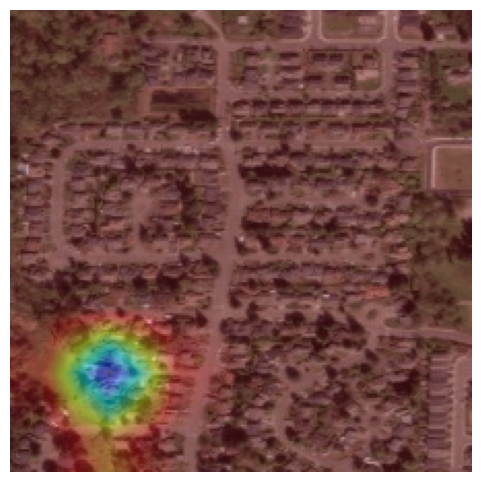

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.show()

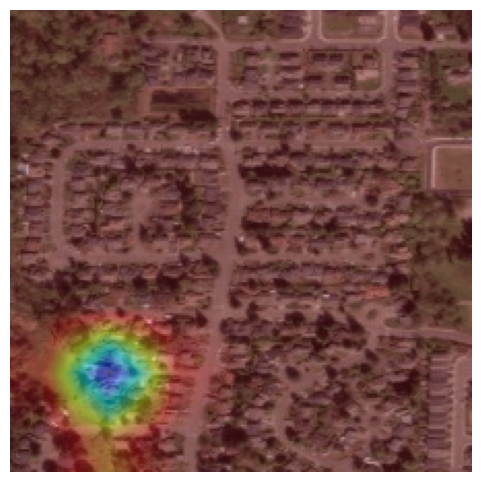

In [34]:
batch = next(iter(test_loader))

x_tab = batch['tabular'][:1].to(device)
zipcode = batch['zipcode'][:1].to(device)
image = batch['image'][:1].to(device)
gradcam = GradCAM(model,target_layer=resnet.layer4)
cam = gradcam.generate(x_tab, zipcode, image)
img = image[0].permute(1,2,0).cpu().numpy()
img = (img - img.min())/(img.max()-img.min())
cam_map = cam[0]
cam_map = cv2.resize(cam_map,(img.shape[1],img.shape[0]));
heatmap = cv2.applyColorMap(
    np.uint8(255*cam_map),
    cv2.COLORMAP_JET
)
heatmap = np.float32(heatmap)/255

overlay = heatmap*0.4+img*0.6
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.show()

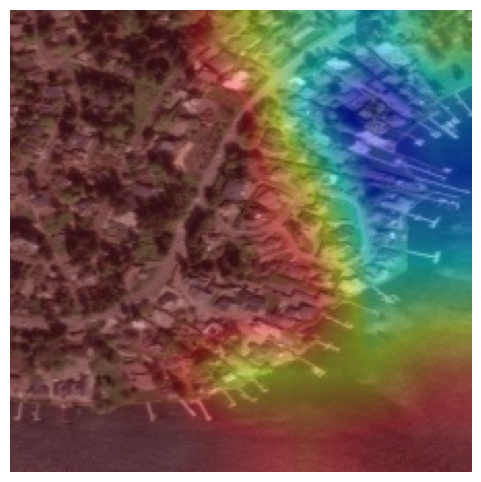

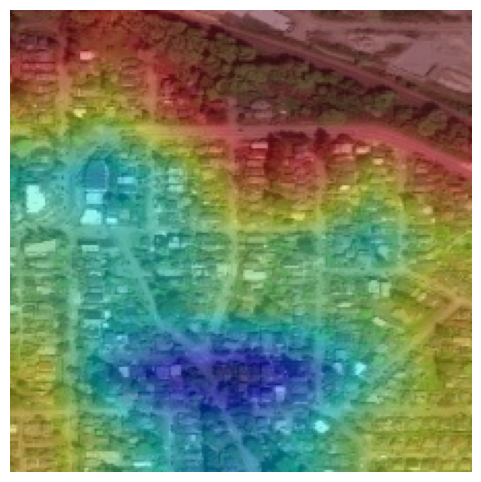

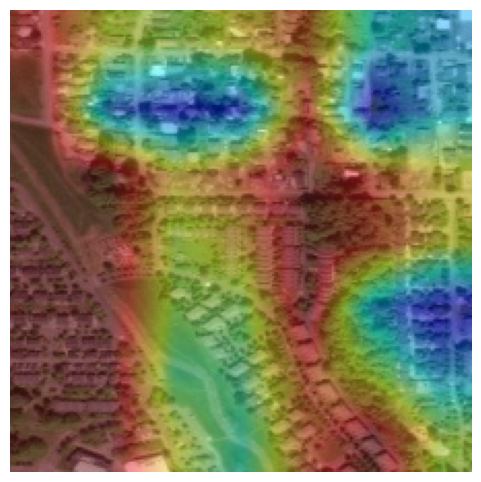

In [35]:
batch = next(iter(test_loader))

indices = [3, 7, 13]

for idx in indices:
    x_tab = batch['tabular'][idx:idx+1].to(device)
    zipcode = batch['zipcode'][idx:idx+1].to(device)
    image = batch['image'][idx:idx+1].to(device)

    gradcam = GradCAM(model, target_layer=resnet.layer4)
    cam = gradcam.generate(x_tab, zipcode, image)

    img = image[0].permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    cam_map = cam[0]
    cam_map = cv2.resize(cam_map, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_map),
        cv2.COLORMAP_JET
    )
    heatmap = np.float32(heatmap) / 255

    overlay = 0.4 * heatmap + 0.6 * img

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()
